In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': 1.,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=0_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9980288591207408, 'loss': 5.089056526198455e-05, 'std': 0.0010900836105367517, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9980288591207408, 'loss': 2.8602779351932217e-05, 'std': 0.0010900836105367517, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 2.204360546055415e-05, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.8415540615294843e-05, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.5980566369620622e-05, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
losses=tensor([[7.3229e-03, 2.1844e-03, 9.2363e+00, 8.9315e+00]])
Elapsed time(grad):4.536
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.035
Fairn

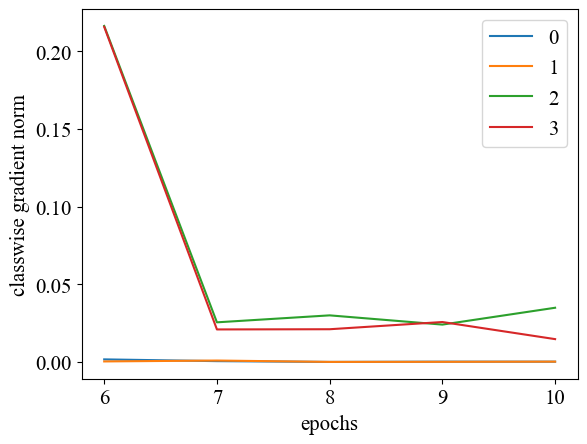

---------------------------- Task 3 -----------------------
losses=tensor([[9.8964e-04, 8.6376e-04, 3.8155e-02, 1.6840e-01, 9.8856e+00, 1.1466e+01]])
Elapsed time(grad):4.234
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):12.743
Fairness:[ 0.35497097  0.49397229  0.25491894 -0.00568913 -0.39092303 -0.7072503 ]
Current class expected loss:tensor([[-0.5773, -1.4113,  0.0230,  1.5867,  3.8981,  5.7960]])
len(updated_seq_indices)=11263
Elapsed time(etc):0.482
temporal training...
temporal training done
[11] Eval metrics for task 1 >> {'accuracy': 0.9242627888159669, 'loss': 0.0011413364122945366, 'std': 0.03344646228535464, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8420082124491519, 'loss': 0.002029879086164723, 'std': 0.028146826310538053, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.947879088160887, 'loss': 0.0006711858631834277, 'std': 0.02971765318330849, 'EER': -1}
losses=tensor([[0.0052, 0.0025, 0.0043, 0.0066, 0.1106, 0.2340]

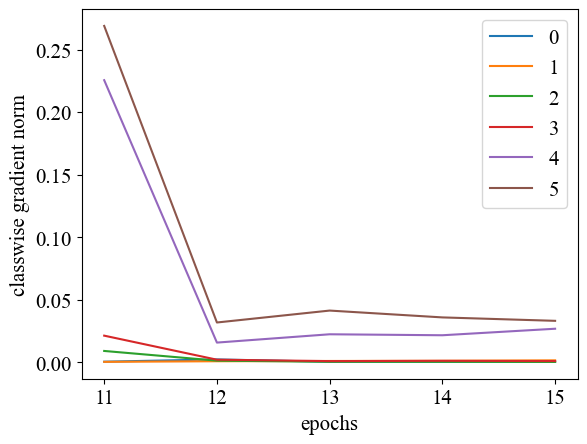

---------------------------- Task 4 -----------------------
losses=tensor([[6.5213e-04, 3.3721e-03, 7.2038e-04, 1.9774e-03, 1.2095e-01, 3.4950e-01,
         1.2310e+01, 9.9604e+00]])
Elapsed time(grad):4.814
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):18.698
Fairness:[ 0.23576155  0.28251966  0.08143818  0.23629296  0.09626414  0.10098284
 -0.67910617 -0.35415338]
Current class expected loss:tensor([[-0.5501, -0.9242,  0.6845, -0.5544,  0.5659,  0.5281,  6.7688,  4.1692]])
len(updated_seq_indices)=12183
Elapsed time(etc):0.645
temporal training...
temporal training done
[16] Eval metrics for task 1 >> {'accuracy': 0.8755618987683179, 'loss': 0.0017901446379668324, 'std': 0.07862312325811383, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.8153609256274464, 'loss': 0.00303176419041416, 'std': 0.0014995394888326352, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.8871628779922004, 'loss': 0.001470924266628929, 'std': 0.02729740714018247

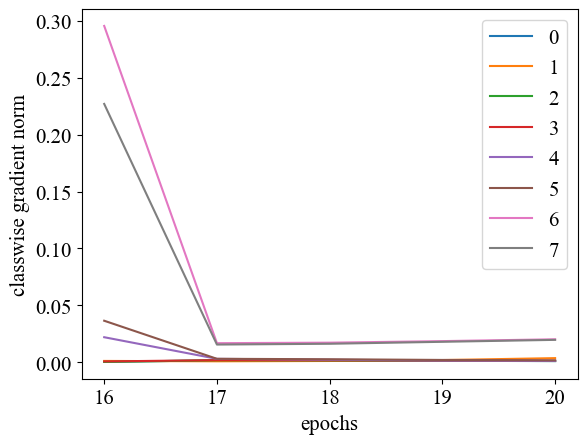

---------------------------- Task 5 -----------------------
losses=tensor([[2.5700e-03, 1.0208e-02, 2.1838e-03, 3.0332e-03, 2.7988e-03, 5.3246e-03,
         5.6573e-02, 9.2024e-02, 1.1582e+01, 1.1557e+01]])
Elapsed time(grad):4.662
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):21.04
Fairness:[ 0.17864551  0.21987538  0.16801026  0.15767609  0.04029749  0.0990343
  0.13496989  0.06078256 -0.55150374 -0.50778792]
Current class expected loss:tensor([[-0.7255, -1.1378, -0.6191, -0.5158,  0.6580,  0.0706, -0.2887,  0.4531,
          6.5760,  6.1388]])
len(updated_seq_indices)=11800
Elapsed time(etc):0.474
temporal training...
temporal training done
[21] Eval metrics for task 1 >> {'accuracy': 0.8783938685606401, 'loss': 0.0018664381957786867, 'std': 0.05288366447900744, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.731846266021951, 'loss': 0.004760238291817945, 'std': 0.025905671962545118, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.80

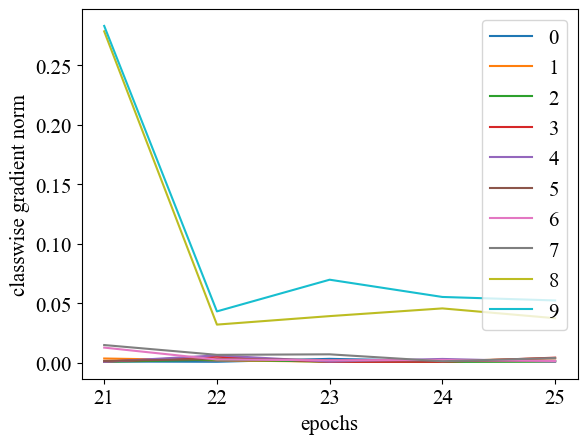

final avg-acc 0.8559892959816076
final avg-forget 0.10472914613595072


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
# losses, *_ = algorithm.get_loss_grad_all(params['num_tasks']) 
# algorithm.true_loss[params['num_tasks']][params['epochs_per_task']] = losses

# num_epochs = params['epochs_per_task']
# for task in range(2, params['num_tasks']):
#     algorithm.true_loss[task][num_epochs] = algorithm.true_loss[task+1][0]


In [7]:
num_class_per_task = 2
num_epochs = params['epochs_per_task']

t = algorithm.true_loss
e = algorithm.expected_loss

groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = dict()
    groupwise_expected_loss[i] = dict()

for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            groupwise_true_loss[i][(task-1)*num_epochs+epoch] = tl
            groupwise_expected_loss[i][(task-1)*num_epochs+epoch] = el
            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


In [8]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][ce], end='\t')
    print()


1.0028	0.0016	0.0002	0.0005	0.0005	0.201	0.0068	0.001	0.0008	0.0008	0.1805	0.0042	0.004	0.0031	0.0027	0.0035	0.0043	0.0115	0.0049	0.0054	
0.4958	0.0031	0.0002	0.0005	0.0008	0.0054	0.0059	0.0063	0.0057	0.0066	0.0225	0.0026	0.0036	0.0065	0.0112	0.1294	0.0067	0.0038	0.0109	0.0137	
0.7546	0.1507	0.2161	0.2252	0.1459	1.3987	0.0053	0.0016	0.0013	0.001	0.6724	0.0049	0.0043	0.0037	0.0029	0.112	0.009	0.0027	0.0029	0.0027	
0.6593	0.1406	0.1933	0.1375	0.1583	2.7289	0.0124	0.0049	0.0048	0.0034	0.2296	0.0058	0.0053	0.0047	0.004	0.783	0.0155	0.0023	0.0067	0.013	
					0.6848	0.1373	0.1631	0.1609	0.194	2.5877	0.0103	0.0075	0.0052	0.0038	1.3329	0.0188	0.0146	0.0095	0.0094	
					0.6262	0.158	0.2493	0.2269	0.2192	1.9599	0.011	0.0095	0.0073	0.006	0.6002	0.0135	0.0086	0.0069	0.0064	
										0.3455	0.1137	0.1164	0.1262	0.1347	0.6806	0.0106	0.0092	0.0085	0.0088	
										0.4248	0.1306	0.1361	0.1503	0.1677	1.9476	0.0499	0.0262	0.0111	0.0115	
															0.2843	0.1612	0.258	0.1965	0.1644	
															

In [9]:
groupwise_true_loss

{0: {6: 1.0028,
  7: 0.0016,
  8: 0.0002,
  9: 0.0005,
  10: 0.0005,
  11: 0.201,
  12: 0.0068,
  13: 0.001,
  14: 0.0008,
  15: 0.0008,
  16: 0.1805,
  17: 0.0042,
  18: 0.004,
  19: 0.0031,
  20: 0.0027,
  21: 0.0035,
  22: 0.0043,
  23: 0.0115,
  24: 0.0049,
  25: 0.0054},
 1: {6: 0.4958,
  7: 0.0031,
  8: 0.0002,
  9: 0.0005,
  10: 0.0008,
  11: 0.0054,
  12: 0.0059,
  13: 0.0063,
  14: 0.0057,
  15: 0.0066,
  16: 0.0225,
  17: 0.0026,
  18: 0.0036,
  19: 0.0065,
  20: 0.0112,
  21: 0.1294,
  22: 0.0067,
  23: 0.0038,
  24: 0.0109,
  25: 0.0137},
 2: {6: 0.7546,
  7: 0.1507,
  8: 0.2161,
  9: 0.2252,
  10: 0.1459,
  11: 1.3987,
  12: 0.0053,
  13: 0.0016,
  14: 0.0013,
  15: 0.001,
  16: 0.6724,
  17: 0.0049,
  18: 0.0043,
  19: 0.0037,
  20: 0.0029,
  21: 0.112,
  22: 0.009,
  23: 0.0027,
  24: 0.0029,
  25: 0.0027},
 3: {6: 0.6593,
  7: 0.1406,
  8: 0.1933,
  9: 0.1375,
  10: 0.1583,
  11: 2.7289,
  12: 0.0124,
  13: 0.0049,
  14: 0.0048,
  15: 0.0034,
  16: 0.2296,
  17: 0.0058,

In [10]:
t = algorithm.true_loss
e = algorithm.expected_loss
# algorithm.true_loss[5][num_epochs] = algorithm.true_loss[5][num_epochs-1]

num_epochs = params['epochs_per_task']
for task in range(2, params['num_tasks']+1):
    print(f"{task=}")
    for epoch in range(1, num_epochs+1):
        print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
        print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
        print()
    print()


task=2
[1.0028 0.4958 0.7546 0.6593]	[1.2612 0.673  2.2289 1.7194]	
[0.0016 0.0031 0.1507 0.1406]	[0.0762 0.0762 0.0762 0.0762]	
[2.000e-04 2.000e-04 2.161e-01 1.933e-01]	[0.1934 0.1006 0.1006 0.0078]	
[0.0005 0.0005 0.2252 0.1375]	[ 0.0515  0.1206  0.0129 -0.    ]	
[0.0005 0.0008 0.1459 0.1583]	[0.0462 0.0645 0.0267 0.0458]	

task=3
[0.201  0.0054 1.3987 2.7289 0.6848 0.6262]	[-0.5773 -1.4113  0.023   1.5867  3.8981  5.796 ]	
[0.0068 0.0059 0.0053 0.0124 0.1373 0.158 ]	[ 0.1545  0.0674  0.1195  0.2255 -0.      0.    ]	
[0.001  0.0063 0.0016 0.0049 0.1631 0.2493]	[0.1517 0.1068 0.1128 0.3054 0.     0.    ]	
[0.0008 0.0057 0.0013 0.0048 0.1609 0.2269]	[0.1542 0.1006 0.1006 0.2483 0.     0.    ]	
[0.0008 0.0066 0.001  0.0034 0.194  0.2192]	[0.1324 0.0941 0.0941 0.244  0.     0.    ]	

task=4
[0.1805 0.0225 0.6724 0.2296 2.5877 1.9599 0.3455 0.4248]	[-0.5501 -0.9242  0.6845 -0.5544  0.5659  0.5281  6.7688  4.1692]	
[0.0042 0.0026 0.0049 0.0058 0.0103 0.011  0.1137 0.1306]	[ 0.0619  0.0619

In [11]:
import copy
task_weight = copy.deepcopy(algorithm.weight_all)

num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out


binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})




task:2
task:3
task:4
task:5


In [12]:
num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [13]:
def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out

In [14]:
binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})

task:2
task:3
task:4
task:5


In [15]:
binned_weight

{2: [{2: {1.0: 5958}, 3: {1.0: 6131}},
  {2: {0.05: 3519, 0.8: 1, 0.9: 1, 1.0: 2437},
   3: {0.05: 3682, 0.7: 1, 1.0: 2448}},
  {2: {0.05: 4490, 1.0: 1468}, 3: {0.05: 4602, 0.1: 1, 1.0: 1528}},
  {2: {0.05: 4230, 1.0: 1728}, 3: {0.05: 4398, 0.65: 1, 1.0: 1732}},
  {2: {0.05: 4161, 1.0: 1797}, 3: {0.05: 4381, 1.0: 1750}}],
 3: [{4: {1.0: 5842}, 5: {1.0: 5421}},
  {4: {0.05: 4616, 0.65: 1, 1.0: 1225}, 5: {0.05: 4122, 1.0: 1299}},
  {4: {0.05: 4969, 1.0: 873}, 5: {0.05: 4427, 0.1: 1, 0.3: 1, 1.0: 992}},
  {4: {0.05: 4973, 0.7: 1, 0.9: 1, 1.0: 867},
   5: {0.05: 4472, 0.25: 1, 0.65: 1, 1.0: 947}},
  {4: {0.05: 5018, 0.3: 1, 1.0: 823},
   5: {0.05: 4554, 0.35: 1, 0.7: 1, 0.95: 1, 1.0: 864}}],
 4: [{6: {1.0: 5918}, 7: {1.0: 6265}},
  {6: {0.05: 5771, 0.3: 1, 0.75: 1, 1.0: 145},
   7: {0.05: 6065, 0.25: 1, 0.5: 1, 1.0: 198}},
  {6: {0.05: 5770, 0.35: 1, 0.45: 1, 0.55: 1, 1.0: 145},
   7: {0.05: 6067, 0.2: 1, 0.5: 1, 1.0: 196}},
  {6: {0.05: 5766, 0.3: 1, 0.65: 1, 1.0: 150},
   7: {0.05: 6061,

In [16]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.974, 0.95 , 0.   , 0.   , 0.   ],
       [0.94 , 0.869, 0.931, 0.   , 0.   ],
       [0.87 , 0.824, 0.909, 0.934, 0.   ],
       [0.863, 0.8  , 0.82 , 0.912, 0.885]])

In [17]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.9229142990212331

In [18]:
[np.round(x, 3) for x in metric_manager_callback.meters['EER'].compute_overall()]

[0.0, 0.012, 0.029, 0.037, 0.037]

In [19]:
np.mean(metric_manager_callback.meters['EER'].compute_overall())

0.023093996433187207

In [20]:
[np.round(x, 3) for x in metric_manager_callback.meters['std'].compute_overall()]

[0.001, 0.012, 0.036, 0.056, 0.059]

In [21]:
np.mean(metric_manager_callback.meters['std'].compute_overall())

0.03275290578806825

In [22]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9229142990212331
EER:0.023093996433187207
std:0.03275290578806825
